In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math
from gee_scripts.parameters import explain_vars, response_var, west_region_ids, center_region_ids


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error


2024-06-17 14:34:27.892675: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 14:34:27.893978: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 14:34:27.913586: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 14:34:27.914029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 14:34:28.246886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

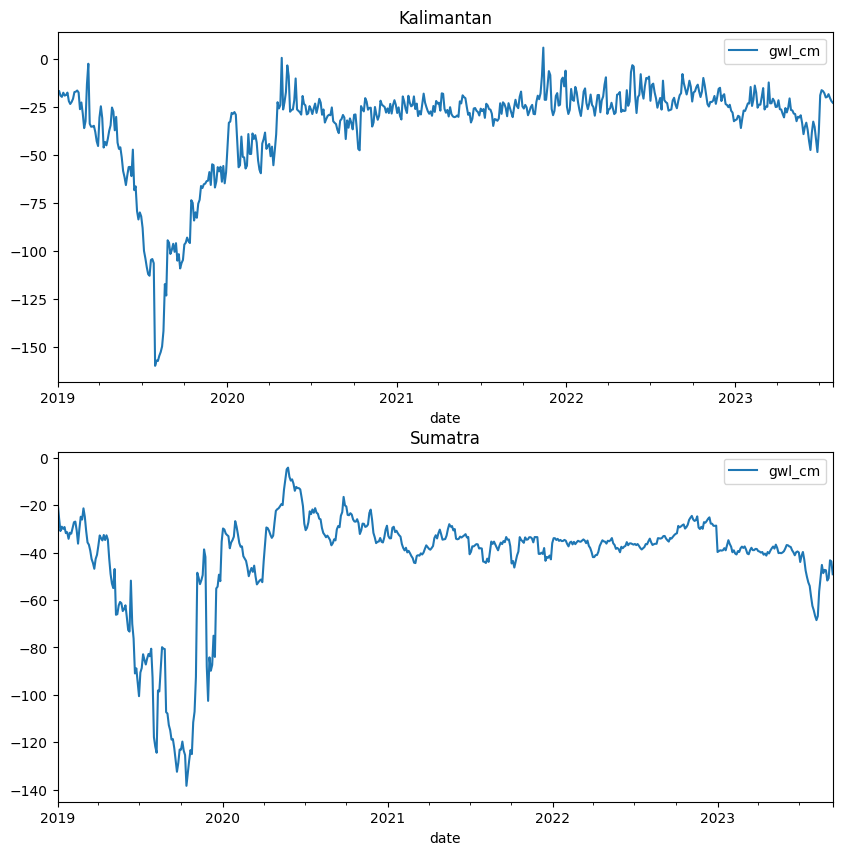

In [22]:
df = pd.read_csv("data/field_data_unique_coords_and_location.csv", parse_dates=["date"])
df = df[(df.gwl_cm <= 400)&(df.date.dt.year>2018)]
df.set_index("date", inplace=True)
# Remove all that is above 400cm
# df = df[["date", "gwl_cm"]]
len(df)

kalimantan_df = df[df.region_id.isin(center_region_ids)][["gwl_cm"]]
sumatra_df = df[df.region_id.isin(west_region_ids)][["gwl_cm"]]


# data = df.sort_values(by="date")
# Set date as index

# sort by date ascending

# Aggregate data every 7 days using mean
kalimantan_resampled = kalimantan_df.resample('3D').mean()
sumatra_resampled = sumatra_df.resample('3D').mean()

# Plot the data in two subplots using seaborn

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

kalimantan_resampled.plot(ax=ax[0], title="Kalimantan")
sumatra_resampled.plot(ax=ax[1], title="Sumatra")

plt.show()

In [23]:
data = kalimantan_df[["gwl_cm"]]

# Setting 80 percent data for training
training_data_len = math.ceil(len(data) * .8)
training_data_len 

#Splitting the dataset
train_data = data[:training_data_len]
test_data = data[training_data_len:]
print(train_data.shape, test_data.shape)

(63856, 1) (15964, 1)


In [24]:
train_data

,gwl_cm
date,
2020-11-05,-37.0
2020-11-17,-39.0
2020-12-05,-39.0
2020-12-16,-35.0
2021-01-02,-34.0
...,...
2019-10-25,-115.3
2019-10-26,-103.0
2019-10-27,-86.2


In [25]:
dataset_train = train_data.gwl_cm.values 
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1)) 
dataset_train.shape


(63856, 1)

In [26]:
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])


[[0.44931507]
 [0.44657534]
 [0.44657534]
 [0.45205479]
 [0.45342466]]


In [27]:
dataset_test = test_data.gwl_cm.values 
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1)) 
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test) 
print(*scaled_test[:5])


[0.64700765] [0.64439805] [0.64318024] [0.64318024] [0.64318024]


In [28]:
X_train = []
y_train = []
for i in range(50, len(scaled_train)):
	X_train.append(scaled_train[i-50:i, 0])
	y_train.append(scaled_train[i, 0])
	if i <= 51:
		print(X_train)
		print(y_train)
		print()


[array([0.44931507, 0.44657534, 0.44657534, 0.45205479, 0.45342466,
       0.45479452, 0.45342466, 0.45205479, 0.45479452, 0.45479452,
       0.45342466, 0.45068493, 0.45753425, 0.45068493, 0.45753425,
       0.44383562, 0.44657534, 0.44520548, 0.44520548, 0.44520548,
       0.44794521, 0.45068493, 0.45068493, 0.44109589, 0.44383562,
       0.44520548, 0.44520548, 0.45342466, 0.45068493, 0.44931507,
       0.45205479, 0.46575342, 0.46438356, 0.46986301, 0.47260274,
       0.46986301, 0.46712329, 0.47260274, 0.46575342, 0.47260274,
       0.46575342, 0.46712329, 0.47945205, 0.47534247, 0.47808219,
       0.47260274, 0.4739726 , 0.46849315, 0.46027397, 0.45616438])]
[0.44794520547945205]

[array([0.44931507, 0.44657534, 0.44657534, 0.45205479, 0.45342466,
       0.45479452, 0.45342466, 0.45205479, 0.45479452, 0.45479452,
       0.45342466, 0.45068493, 0.45753425, 0.45068493, 0.45753425,
       0.44383562, 0.44657534, 0.44520548, 0.44520548, 0.44520548,
       0.44794521, 0.45068493, 0.45

In [29]:
X_test = []
y_test = []
for i in range(50, len(scaled_test)):
	X_test.append(scaled_test[i-50:i, 0])
	y_test.append(scaled_test[i, 0])


In [30]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)


X_train : (63806, 50, 1) y_train : (63806, 1)


In [31]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)


X_test : (15914, 50, 1) y_test : (15914, 1)


In [ ]:
def get_callbacks(model_name: str = 'model'):

    checkpoint_name = model_name + 'epoch_{epoch:02d}.h5'

    # Setup model checkpoint
    checkpoint_callback = ModelCheckpoint(
        checkpoint_name,  # Saves the model with the epoch number in the filename
        save_weights_only=False,       # Can set to True if you only want to save weights
        save_best_only=False,          # Every epoch's model will be saved, not just the best
        verbose=1
    )


    # Setup early stopping
    early_stopping_callback = EarlyStopping(
        monitor='loss',  # Monitor validation loss (or adjust according to your setup)
        min_delta=0.001,  # Minimum change to qualify as an improvement
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        verbose=1,
        restore_best_weights=True  # This rolls back to the best model
    )

    return [checkpoint_callback, early_stopping_callback]


In [35]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50, 
						activation = "tanh",
						return_sequences = True,
						input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50, 
						activation = "tanh",
						return_sequences = True))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
								decay=1e-6, 
								momentum=0.9, 
								nesterov=True), 
				loss = "mean_squared_error")

# fitting the model
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32, callbacks=get_callbacks("simple_rnn"))
regressor.summary()


Epoch 1/20
1993/1994 [============================>.] - ETA: 0s - loss: 7.9951e-04
Epoch 1: saving model to model_epoch_01.h5
1994/1994 [==============================] - 27s 13ms/step - loss: 7.9930e-04
Epoch 2/20
1993/1994 [============================>.] - ETA: 0s - loss: 4.2810e-04
Epoch 2: saving model to model_epoch_02.h5
1994/1994 [==============================] - 26s 13ms/step - loss: 4.2799e-04
Epoch 3/20
1994/1994 [==============================] - ETA: 0s - loss: 3.7685e-04
Epoch 3: saving model to model_epoch_03.h5
1994/1994 [==============================] - 26s 13ms/step - loss: 3.7685e-04
Epoch 4/20
1994/1994 [==============================] - ETA: 0s - loss: 3.4638e-04
Epoch 4: saving model to model_epoch_04.h5
1994/1994 [==============================] - 27s 13ms/step - loss: 3.4638e-04
Epoch 5/20
1992/1994 [============================>.] - ETA: 0s - loss: 3.2967e-04
Epoch 5: saving model to model_epoch_05.h5
1994/1994 [==============================] - 27s 14ms/step

In [39]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50, return_sequences = False))
regressorLSTM.add(Dense(25))

#Adding the output layer
regressorLSTM.add(Dense(1))

#Compiling the model
regressorLSTM.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ["accuracy"])

#Fitting the model
regressorLSTM.fit(
    X_train, 
    y_train, 
    batch_size = 8, 
    epochs = 12, 
    callbacks=get_callbacks("LSTM_model_epoch_{epoch:02d}.h5")
)
regressorLSTM.summary()


Epoch 1/12


2024-06-17 14:43:35.103713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-17 14:43:35.104219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-17 14:43:35.104897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7974/7976 [============================>.] - ETA: 0s - loss: 3.6570e-04 - accuracy: 3.4487e-04
Epoch 1: saving model to LSTM_model_epoch_01.h5
7976/7976 [==============================] - 149s 18ms/step - loss: 3.6567e-04 - accuracy: 3.4480e-04
Epoch 2/12
7976/7976 [==============================] - ETA: 0s - loss: 2.0946e-04 - accuracy: 3.4480e-04
Epoch 2: saving model to LSTM_model_epoch_02.h5
7976/7976 [==============================] - 131s 16ms/step - loss: 2.0946e-04 - accuracy: 3.4480e-04
Epoch 3/12
7975/7976 [============================>.] - ETA: 0s - loss: 1.9994e-04 - accuracy: 3.4483e-04
Epoch 3: saving model to LSTM_model_epoch_03.h5
7976/7976 [==============================] - 149s 19ms/step - loss: 1.9994e-04 - accuracy: 3.4480e-04
Epoch 4/12
3570/7976 [============>.................] - ETA: 1:22 - loss: 1.9450e-04 - accuracy: 4.9020e-04

In [ ]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
regressorGRU.add(GRU(units=50, activation='tanh'))
# The output layer
regressorGRU.add(Dense(units=1, activation='relu'))

# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# Fitting the data
regressorGRU.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=1, 
    callbacks=get_callbacks("GRU")
)

regressorGRU.summary()


In [ ]:
# predictions with X_test data
y_RNN = regressor.predict(X_test)
# y_LSTM = regressorLSTM.predict(X_test)
y_GRU = regressorGRU.predict(X_test)

In [ ]:
# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN) 
# y_LSTM_O = scaler.inverse_transform(y_LSTM) 
y_GRU_O = scaler.inverse_transform(y_GRU)


In [ ]:
y_RNN_O

In [ ]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
axs[0].plot(train_data.index[150:], train_data.gwl_cm[150:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data.gwl_cm, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for LSTM predictions
axs[1].plot(train_data.index[150:], train_data.gwl_cm[150:], label = "train_data", color = "b")
axs[1].plot(test_data.index, test_data.gwl_cm, label = "test_data", color = "g")
# axs[1].plot(test_data.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
# axs[1].legend()
# axs[1].title.set_text("LSTM")

#Plot for GRU predictions
axs[2].plot(train_data.index[150:], train_data.gwl_cm[150:], label = "train_data", color = "b")
axs[2].plot(test_data.index, test_data.gwl_cm, label = "test_data", color = "g")
axs[2].plot(test_data.index[50:], y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("gwl_cm price")

plt.show()
